In [3]:
import sys
import unittest

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchsummary

%matplotlib inline

# Tensors

A tensor is an n-dimensional array consisting of elements of the same type. Every tensor has an associated shape that describes the dimensions of the tensor. For example, the shape of a 4D tensor would have four numbers that specify the size of each of the four dimensions.

- **vector:** 1D tensor with shape `[N]` where N denotes the number of elements
- **matrix:** 2D tensor with shape `[R, C]` where R and C denote the number of rows and columns, respectively
- **RGB image:** 3D tensor with shape `[C, H, W]` where C denotes the number of channels (representing color) and H and W denote the height and width, respectively

The number of tensor dimensions is known as "the rank of the tensor". Each tensor dimension is known as "an axis" of the tensor. An axis with a dimension of one is known as a singleton axis. Example usage: "In a rank four tensor of shape `[N, C, H, W]`, N denotes the dimension/size of the leading axis."

A tensor containing a batch of images would typically have the following shape: [N, C, H, W]. `N` indicates the number of images in the batch, `C` indicates the number of channels (one for grayscale images and typically three for color images), H and W are the height and width of the image respectively. Note that the dimensions of each image is fixed; we cannot store images of different sizes in the same tensor.

# Convolution Arithmetic

The convolution operation takes two tensors as input and results in one tensor as output (sometimes, we add a "bias" tensor to the result after convolving). The shape of the output tensor depends on the shape of the input tensor, weights/filters tensor, and convolution configuration such as padding.

The convolution layer in a neural network generally convolves the same input with many filters (ranging from few dozen to hundreds to thousands). It is equivalent to convolving the image with each filter separately and then concatenating the results into a single tensor. We also often convolve the same set of filters on a collection of input tensors (like in minibatch gradient descent).

Using the visualizations below as an aid, write a function that outputs the shape of the output tensor for a given input shape, filters shape, and convolution configuration.

<table>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Padding of one, no strides</td>
    <td>Padding of two, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif"></td>
  </tr>
  <tr>
    <td>No padding, stride of two</td>
    <td>Padding of one, stide of two</td>
    <td>Padding of one, stride of two</td>
  </tr>
</table>

**References:**
"A guide to convolution arithmetic for deep learning", https://arxiv.org/abs/1603

License for images: https://github.com/vdumoulin/conv_arithmetic/blob/master/LICENSE


In [3]:
def getConvolutionOutputShape(B, C, H, W, K, M, N, Ph=0, Pw=0, Sh=1, Sw=1):
    """
    Computes the output shape of 2D convolution for a given input and filters shape

    Input shape: [B, C, H, W]
    Filters shape: [K, C, H, W]

    Padding and strides are relevant for spatial dimensions only (height and width).

    Args:
    B: batch size
    C: number of input channels
    H: height of the input
    W: width of the input
    K: number of filters
    M: height of the filters
    N: width of the filters
    Ph: vertical padding
    Pw: horizontal padding
    Sh: vertical stride
    Sw: horizontal stride
    """

    output_shape = np.zeros(4, dtype=int)

    # the calculation is independent and identical for each spatial axis
    def calculate_output_dim((B, C, H, W, K, C, M, N, Ph, Pw, Sh, Sw):
        """returns the output dimension for a spatial axis"""
        # YOUR CODE BEGINS HERE
        output_batch = B
        output_channels = K
        output_height = ((H + 2*Ph - M + 1)/Sh)
        output_width = ((W + 2*Pw - N + 1)/Sw)
    return (output_batch, output_channels, output_height, output_width)
    # YOUR CODE ENDS HERE

    # YOUR CODE BEGINS HERE
    result = calculate_output_dim(B, C, H, W, K, C, M, N, Ph, Pw, Sh, Sw)
    output_shape[0] = result[0]
    output_shape[1] = result[1]
    output_shape[2] = result[2]
    output_shape[3] = result[3]
    # YOUR CODE ENDS HERE

    return list(output_shape)

In [4]:
class Test_getConvolutionOutputShape(unittest.TestCase):
    def test_simple(self):
        self.assertEqual(getConvolutionOutputShape(1, 1, 28, 32, 16, 3, 3), [1, 16, 26, 30])
        self.assertEqual(getConvolutionOutputShape(5, 3, 32, 28, 32, 3, 3), [5, 32, 30, 26])
        self.assertEqual(getConvolutionOutputShape(7, 256, 28, 28, 64, 3, 1), [7, 64, 26, 28])
        self.assertEqual(getConvolutionOutputShape(11, 256, 28, 28, 128, 1, 3), [11, 128, 28, 26])
        self.assertEqual(getConvolutionOutputShape(13, 1, 64, 64, 16, 5, 5), [13, 16, 60, 60])

    def test_padding(self):
        self.assertEqual(getConvolutionOutputShape(1, 1, 32, 28, 16, 3, 3, 1, 1), [1, 16, 32, 28])
        self.assertEqual(getConvolutionOutputShape(1, 16, 28, 32, 32, 3, 3, 3, 3), [1, 32, 32, 36])
        self.assertEqual(getConvolutionOutputShape(1, 33, 28, 28, 64, 3, 1, 1, 0), [1, 64, 28, 28])
        self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
        self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
        self.assertEqual(getConvolutionOutputShape(1, 4, 7, 11, 16, 5, 5, 2, 2), [1, 16, 7, 11])

    def test_strides(self):
        self.assertEqual(getConvolutionOutputShape(1, 1, 28, 28, 16, 3, 3, 0, 0, 2, 2), [1, 16, 13, 13])
        self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 32, 3, 3, 1, 1, 2, 2), [1, 32, 14, 14])
        self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 64, 3, 1, 2, 2, 2, 2), [1, 64, 15, 16])
        self.assertEqual(getConvolutionOutputShape(1, 128, 28, 28, 128, 1, 3, 0, 1, 4, 4), [1, 128, 7, 7])

    def test_misc(self):
        self.assertEqual(getConvolutionOutputShape(1, 1, 13, 13, 16, 1, 1), [1, 16, 13, 13])

unittest.main(Test_getConvolutionOutputShape(), argv=[''], verbosity=2, exit=False)

test_misc (__main__.Test_getConvolutionOutputShape) ... ok
test_padding (__main__.Test_getConvolutionOutputShape) ... ok
test_simple (__main__.Test_getConvolutionOutputShape) ... ok
test_strides (__main__.Test_getConvolutionOutputShape) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.018s

OK


# Convolution

Implement the `convolve2d` that convolves a filter (unit strides and zero padding) on a greyscale image. The animated visual aid shows this configuration.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"/>

In [5]:
def convolve2d(image, kernel):
    """
    Convolve a 2D image with a kernel (2D filter)

    Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
    """

    image = np.asarray(image)
    kernel = np.asarray(kernel)

    H, W = image.shape
    M, N = kernel.shape

    # YOUR CODE BEGINS HERE
    result_H = 1 + H - M
    result_W = 1 + W - N
    # YOUR CODE ENDS HERE

    result = np.zeros((result_H, result_W), dtype=np.float32)
    # YOUR CODE BEGINS HERE
    # Implement convolution using two loops
    for i in range(result_H):
        for j in range(result_W):
            result[i][j] = (image[i:i+M, j:j+N] * kernel).sum()
    # YOUR CODE ENDS HERE

    return result

In [6]:
def convolve2d_ref(image, kernel):
    from scipy import signal
    return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d(unittest.TestCase):
    def test(self):
        image1 = np.random.random((16, 16))
        kernel1 = np.ones((3, 3), dtype=np.float32)
        kernel1 /= np.sum(kernel1)
        self.assertTrue(np.allclose(convolve2d(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

        image2 = np.random.random((32, 32))
        kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
        kernel2 /= np.sum(kernel2)
        self.assertTrue(np.allclose(convolve2d(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

        image3 = np.random.random((256, 256))
        kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
        kernel3 /= np.sum(np.abs(kernel3))
        self.assertTrue(np.allclose(convolve2d(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.423s

OK


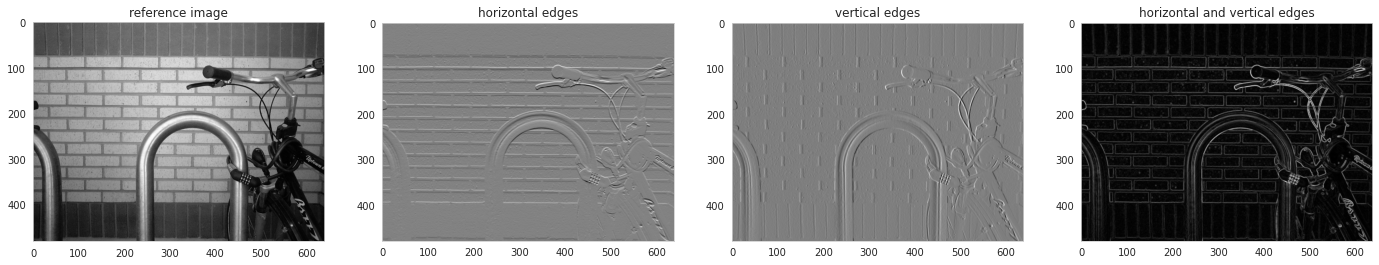

In [7]:
import skimage.io as sio
image = sio.imread("https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg", as_gray=True)

# https://en.wikipedia.org/wiki/Sobel_operator
sobel_filter_horizontal = np.asarray([
  [ 1,  2,  1],
  [ 0,  0,  0],
  [-1, -2, -1]
], dtype=np.float32)

sobel_filter_vertical = sobel_filter_horizontal.T

# convolve image with Sobel operators using your implementation
image_sobel_h = convolve2d(image, sobel_filter_horizontal)
image_sobel_v = convolve2d(image, sobel_filter_vertical)
image_sobel_hv =  np.sqrt(image_sobel_h**2 + image_sobel_v**2)

# convolve image with Sobel operators using reference implementation
image_sobel_h_ref = convolve2d_ref(image, sobel_filter_horizontal)
image_sobel_v_ref = convolve2d_ref(image, sobel_filter_vertical)

fig, axes = plt.subplots(1, 4, figsize=(24,6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("reference image")
axes[1].imshow(image_sobel_h, cmap='gray')
axes[1].set_title("horizontal edges")
axes[2].imshow(image_sobel_v, cmap='gray')
axes[2].set_title("vertical edges")
axes[3].imshow(image_sobel_hv, cmap='gray')
axes[3].set_title("horizontal and vertical edges")
plt.show()

# Convolution as Matrix Multiplication

Convolution is a linear operation. We can represent convolution as a matrix multiplication of a transformed filter matrix with the input matrix.

Consider an input $\mathbf{X}$ and a kernel $\mathbf{W}$.

$$$$

$$\mathbf{X} = \begin{pmatrix}x_{00} & x_{01} & x_{02} \\ 
x_{10} & x_{11} & x_{12} \\ 
x_{20} & x_{21} & x_{22} \end{pmatrix}\$$

$$\mathbf{W} = \begin{pmatrix}w_{00} & w_{01} \\ w_{10} & w_{11} \end{pmatrix}$$

$$$$

Let the result of the convolution of $\mathbf{X}$ with $\mathbf{W}$ be denoted by $\mathbf{Y}$.

$$\mathbf{Y} = \mathbf{X} * \mathbf{Y}$$

$$\mathbf{Y} = \begin{pmatrix}
w_{00}*x_{00} + w_{01}*x_{01} + w_{10}*x_{10} + w_{11}*x_{11} &
w_{00}*x_{01} + w_{01}*x_{02} + w_{10}*x_{11} + w_{11}*x_{12} \\
w_{00}*x_{10} + w_{01}*x_{11} + w_{10}*x_{20} + w_{11}*x_{21} &
w_{00}*x_{11} + w_{01}*x_{12} + w_{10}*x_{21} + w_{11}*x_{22}
 \end{pmatrix}$$

$$$$

We can express the result as matrix multiplication of a transformed weight matrix with the input matrix.

$$\mathbf{Y} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

1. Assuming the input and kernel shape to be `[H, W]` and `[M, N]` respectively, what is the shape of the transformed kernel matrix?
2. Complete the `transform_kernel` function. It must construct the transformed kernel matrix for a given input shape and kernel matrix.
3. Complete the `convolve2d_matmul` function. It must convolve the input with the given kernel using the transformed matrix.

**References:**
- https://github.com/alisaaalehi/convolution_as_multiplication

## Answers

1. The size of the transformed kernel is $size = (H-M+1)*(W-N+1)\times(H*W)$. The matrix $Y$ can be written as $\large Y_{\small (H-M+1)(W-N+1)\times(HW)}$

In [8]:
def transform_kernel(image, kernel):
    """
    Transform kernel matrix into a new matrix such that matrix multiplication of
    the transformed matrix with the flattened input gives the result of convolution.

    Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
    """

    image = np.asarray(image)
    kernel = np.asarray(kernel)

    H, W = image.shape
    M, N = kernel.shape

    # YOUR CODE BEGINS HERE
    result_H = H-M+1 # height of the output
    result_W = W-N+1 # width of the output

    # YOUR CODE ENDS HERE
    transformed_kernel = np.zeros((result_H * result_W, H * W), dtype=np.float32)
    # YOUR CODE BEGINS HERE

    stride_zeros = 0
    for row in range(transformed_kernel.shape[0]):
        k = 0
        if stride_zeros == W-N+1:
            stride_zeros=0
        for app_zeros in range((row//(W-N+1))*W+stride_zeros):
            k+=1
        for i in range(M):
            for j in range(N):
                transformed_kernel[row,k] = kernel[i,j]
                k+=1
            for app_zeros in range(W-N):
                k+=1
        stride_zeros+=1
    # YOUR CODE ENDS HERE

    return transformed_kernel

def convolve2d_matmul(image, kernel):
    """
    Convolve a 2D image with a 2D kernel

    Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
    """

    image = np.asarray(image)
    kernel = np.asarray(kernel)

    H, W = image.shape
    M, N = kernel.shape

    # YOUR CODE BEGINS HERE
    result_H = H - M + 1
    result_W = W - N + 1
    # YOUR CODE ENDS HERE

    # YOUR CODE BEGINS HERE
    # 1. compute transformed kernel
    transformed_kernel = transform_kernel(image, kernel)
    # 2. flatten input (reshape the 2D input to a 1D column vector)
    flattened_input = image.ravel()
    flattened_input = np.reshape(flattened_input, (flattened_input.shape[0],1))
    # 3. matrix multiplication
    result =  np.matmul(transformed_kernel, flattened_input)
    # 4. reshape result (reshape back to 2D output from a 1D column vector)
    result = np.reshape(result,(result_H,result_W))
    # YOUR CODE ENDS HERE

    return result

In [9]:
def convolve2d_ref(image, kernel):
    from scipy import signal
    return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d_matmul(unittest.TestCase):
    def test(self):
        image1 = np.random.random((16, 16))
        kernel1 = np.ones((3, 3), dtype=np.float32)
        kernel1 /= np.sum(kernel1)
        self.assertTrue(np.allclose(convolve2d_matmul(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

        image2 = np.random.random((32, 32))
        kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
        kernel2 /= np.sum(kernel2)
        self.assertTrue(np.allclose(convolve2d_matmul(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

        image3 = np.random.random((64, 64))
        kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
        kernel3 /= np.sum(np.abs(kernel3))
        self.assertTrue(np.allclose(convolve2d_matmul(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d_matmul(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d_matmul) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.705s

OK


## Comparing convolutional layer with fully-connected layer

$$\mathbf{Y}_{fc} = \begin{pmatrix}
w_{00} & w_{01} & w_{02} & w_{03} & w_{04} & w_{05} & w_{06} & w_{07} & w_{08} & w_{09} \\
w_{10} & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & w_{16} & w_{17} & w_{18} & w_{19} \\
w_{20} & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & w_{26} & w_{27} & w_{28} & w_{29} \\
w_{30} & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & w_{36} & w_{37} & w_{38} & w_{39}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

$$\mathbf{Y}_{conv} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

## Questions

1. Express the number of learnable parameters in a fully-connected layer (without bias) in terms of `B`, `K`, `C`, `H`, `W`, `M` and `N` (as defined earlier).
2. Express the number of learnable parameters in a convolutional layer (without bias) in terms of the number of inputs `N` and outputs `M`.
4. Imagine weight matrices of a convolutional and fully-connected layer such that both operations result in the same output shape for a given input shape (the transformed toeplitz matrix must have the same shape of the fully-connected layer weights). Run the next code cell. What patterns do you observe in the weights? Is the weights matrix dense or sparse?
4. Explain what you understand by the terms "sparse connectivity" and "weight sharing" in the context of convolutional layers.
5. If a fully-connected layer can mimic convolution and is more powerful in terms of the set of functions it can represent, what is the point of using convolutions instead of them?

## Answers

1. The number of learnable parameters in a fully-connected layer(without) bias given $B,K,C,H,W,M,N$ is **The product of no of elements in output layer and no of elements of input layer**
$$
    \text{No of elememts in output layer} = (H-M+1)*(W-N+1)*K\\
    \text{No of elements in input layer} = H*W*C\\ 
    \therefore \text{No of learnable parameters in fully connected is} = size_{input}*size_{output}\\ 
    = (H-M+1)*(W-N+1)*K*H*W*C
$$

2. In the case of convolution matrix, the matrix is sparse as majority of the elements are $0$. The number of learnable parameters in the each transformation matrix is
$$
   \therefore\text{The number of learnable parameters} = M*N*K*C \\ 
   \text{  (considering that no of channels each in filter is no of channels in input)} \\ 
$$

3. After running the below cell, we can observe that
    - The kernel matrix for fully connected layer was found to be *`dense`* but the kernel matrix for the convolutional layer was found to be *`sparse`*.
    - Since the kernel matrix for the fully connected layer is denses, all the kernel values will be used in computing the output and hence it will be more costly operation compared to convolutional layers.
    - Most of the elements in the convolutional kernel were zero and hence it will be more efficient.

4. **Sparse connectivity:** Unlike in fully connected layer, where every input node is connected to all the output nodes, the connections in CNN are sparse, because in CNN,  only the region which is the size of the filter is observed each time, instead of considering all the pixels/data. CNNs are inherently sparse hence cost effective.

5. **Weight sharing:** In weight sharing, weights are shared between two convolutional layers. It is the property of using a small set of weights over a comparitively large input. It can also be seen as particular layers of two different networks sharing some weights, meaning each filter is duplicated throughout the input. These duplicated units constitute a feature map which share the same parameters (weight vector and bias). When any one of them is trained, the shared weight gets updated, and the other gets to see it as well. This can be seen in `siamese networks` which has two networks trained in paralled with shared weights between two of them.

6. Why choose Convolutional Layers instead of Fully Connected layers?
    - Though *fullyconnected layers* are powerful (mainly in classification and regression due to set of functions they can represent), they are not better than CNN in extracting features from images because we use filters in CNN, which convolve over image and extract features and the plus factor is it is shift invariant and easy to operate.
    - Other main reason for choosing CNN is *Fully connected layer has way more learnable parameters than Convolution layer and takes much more computational time that CNN to learn*.
    - Fully connected layers require a defined input size but convolutional layers can be used on varying input sizes.

In [10]:
with np.printoptions(threshold=sys.maxsize, linewidth=128):
  print("A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)")
  print(np.arange(9 * 25, dtype=np.float32).reshape(9, 25))
  print()

  print("Transformed matrix for 3x3 kernel that operates on an input with shape 5x5")
  print(transform_kernel(np.zeros((5, 5)), [[1, 2, 3], [4, 5, 6], [7, 8, 9]]))
  print()

A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)
[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.]
 [ 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.]
 [ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.]
 [ 75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.]
 [100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]
 [125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]
 [150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168

# Training Convolutional Neural Networks

You have to train an image classifier for CIFAR10 dataset. There are ten classes/labels in the dataset. Each image has the shape 3x32x32 (32 pixels wide and tall, with 3 color channels).The dataset consists of 50,000 training samples and 10,000 test samples.

In [11]:
# On Google Colab: Go to "Runtime" > "Change runtime type" > Select "GPU"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=False, transform=transform)

print("training dataset size:", len(train_dataset))
print("test dataset size:", len(test_dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
training dataset size: 50000
test dataset size: 10000


In [13]:
# YOUR CODE BEGINS HERE
# portion a part of the training dataset for validation
# use 90% of the training dataset for training and the rest for validation
# use `torch.utils.data.random_split`

# YOUR CODE ENDS HERE
from torch.utils.data import random_split

train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("training dataset size:", train_size)
print("validation dataset size:", valid_size)

training dataset size: 45000
validation dataset size: 5000


In [14]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset)
test_dataloader = torch.utils.data.DataLoader(test_dataset)

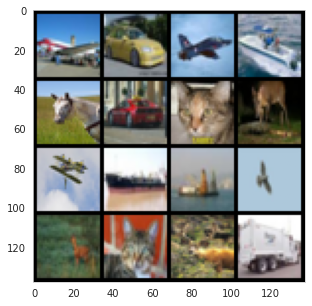

In [15]:
images, _ = next(iter(train_dataloader))
images = images * 0.5 + 0.5 # undo normalization for displaying images
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1, 2, 0))

In [16]:
class SMAIConvNet(nn.Module):
    def __init__(self):
        super(SMAIConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # YOUR CODE BEGINS HERE
        # Conv2D with 32 filters, 3x3 kernel and 'same' padding
        # MaxPool2D with with window size 2x2
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Conv2D with 32 filters, 3x3 kernel and 'same' padding
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')

        # Linear layer with 128 output features
        # Dropout with drop probability of 0.2
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(8*8*32, 128)
        self.dropout1 = nn.Dropout(p=0.2)

        # Linear layer with 10 output features
        self.fc2 = nn.Linear(128, 10)
        # YOUR CODE ENDS HERE

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x)

        # YOUR CODE BEGINS HERE
        # conv2 > maxpool2 > ReLU
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x)

        # conv3 > ReLU
        x = self.conv3(x)
        x = F.relu(x)

        # fc1 > dropout1 > ReLU
        x = self.fl(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = F.relu(x)

        # # fc2
        x = self.fc2(x)

        # YOUR CODE ENDS HERE
        return x


In [17]:
torchsummary.summary(SMAIConvNet().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           2,336
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           9,248
           Flatten-6                 [-1, 2048]               0
            Linear-7                  [-1, 128]         262,272
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 275,370
Trainable params: 275,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 1.05
Estimated Total Size (MB): 1.25
-------------------------------------------

In [18]:
def train(model, device, train_dataloader, optimizer, criterion):
    """trains for one epoch"""

    model.train()
    accumulated_loss = 0.0
    for data in train_dataloader:
        (inputs, labels) = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # YOUR CODE BEGINS HERE
        # 1. zero existing gradients
        optimizer.zero_grad()
        # 2. forward the inputs
        op = model(inputs)#same as model.forward()
        # 3. compute the loss
        loss = criterion(op, labels)
        # 4. backprop the loss
        loss.backward()
        # 5. update the weights
        optimizer.step()
        # YOUR CODE ENDS HERE

        accumulated_loss += loss.item()
    return accumulated_loss / len(train_dataloader)

def test(model, device, dataloader, criterion):
    model.eval()
    accumulated_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            (inputs, labels) = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # YOUR CODE BEGINS HERE
            # 1. forward the inputs
            op = model(inputs)#same as model.forward()
            # 2. compute the loss
            loss = criterion(op, labels)
            # YOUR CODE ENDS HERE

            accumulated_loss += loss.item()

            predictions = op.argmax(dim=1)
            correct += (predictions == labels).sum()

        num_samples = len(dataloader)
        avg_loss = accumulated_loss / num_samples
    return avg_loss, correct / num_samples
    

In [19]:
model = SMAIConvNet().to(device) # resets parameters

# YOUR CODE BEGINS HERE
# use CrossEntropyLoss
# use SGD with a lr=0.001 and momentum=0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# YOUR CODE ENDS HERE

best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model.state_dict(), "best_model.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

new best model
[1] training loss: 1.93
[1] validation loss: 1.59, validation accuracy: 42.56%

new best model
[2] training loss: 1.51
[2] validation loss: 1.41, validation accuracy: 48.98%

new best model
[3] training loss: 1.36
[3] validation loss: 1.29, validation accuracy: 53.18%

new best model
[4] training loss: 1.24
[4] validation loss: 1.19, validation accuracy: 56.88%

new best model
[5] training loss: 1.14
[5] validation loss: 1.16, validation accuracy: 59.40%

new best model
[6] training loss: 1.05
[6] validation loss: 1.02, validation accuracy: 63.90%

new best model
[7] training loss: 0.98
[7] validation loss: 0.99, validation accuracy: 64.94%

new best model
[8] training loss: 0.92
[8] validation loss: 0.95, validation accuracy: 66.16%

new best model
[9] training loss: 0.86
[9] validation loss: 0.95, validation accuracy: 67.16%

new best model
[10] training loss: 0.81
[10] validation loss: 0.93, validation accuracy: 67.88%

new best model
[11] training loss: 0.75
[11] val

In [20]:
model.load_state_dict(torch.load("best_model.pth"))

test_loss, test_acc = test(model, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%" % (test_loss, test_acc * 100))

test loss: 0.88, test accuracy: 69.80%


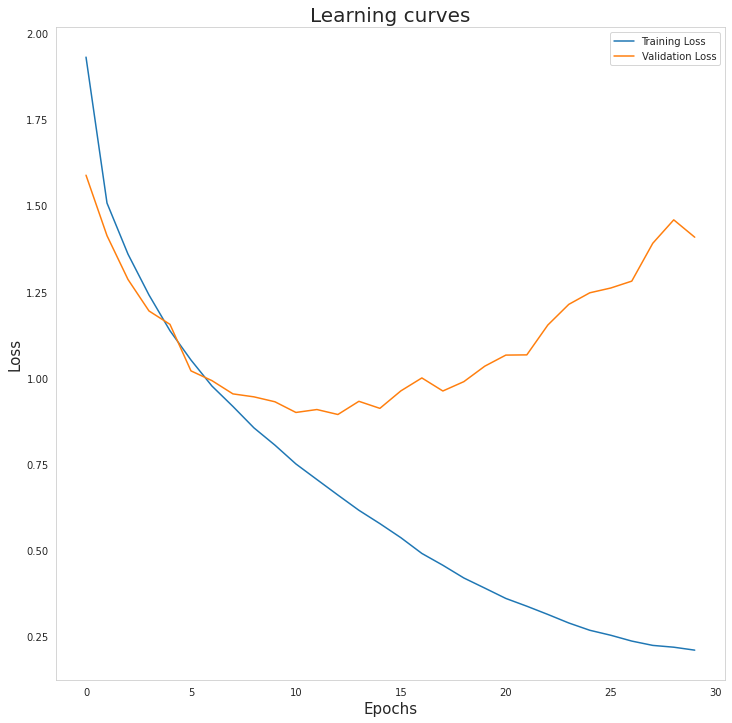

In [22]:
# plot the learning curve
# plot validation and training loss in the same plot against number of epochs (use `loss_history`)
# YOUR CODE BEGINS HERE
plt.figure(figsize=(12,12))
plt.plot(loss_history['train'], label="Training Loss")
plt.plot(loss_history['validation'], label="Validation Loss")
plt.title("Learning curve of the above model")
plt.legend(loc = "best")
plt.xlabel('Epochs' ,size = 15)
plt.ylabel('Loss',size=15)
plt.title('Learning curves', size=20)
plt.show()
# YOUR CODE ENDS HERE

### Questions

1. What do you observe in the learning curve? Why do we require a validation set?
2. Train the network five times. Note the following quantities in a table (in the code cell below):
  - final training loss
  - best model validation loss and accuracy
  - best model test accuracy
3. Summarize your observations from the table. Does the performance differ in each round of training? What would happen if design decisions are based solely on the validation set performance from a single round of training?
4. Propose a scheme to summarize the overall performance of the model with statistics from multiple training rounds. Using the the table in the next cell, write code to summarize model performance.

In [23]:
###################################### RUN 1 ################################################
model_1 = SMAIConvNet().to(device) # resets parameters

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)


best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model_1, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model_1, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model_1.state_dict(), "best_model_1.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

model_1.load_state_dict(torch.load("best_model_1.pth"))

test_loss, test_acc = test(model_1, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%\n\n" % (test_loss, test_acc * 100))


###################################### RUN 2 ################################################
model_2 = SMAIConvNet().to(device) # resets parameters

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)


best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model_2, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model_2, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model_2.state_dict(), "best_model_2.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

model_2.load_state_dict(torch.load("best_model_2.pth"))

test_loss, test_acc = test(model_2, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%\n\n" % (test_loss, test_acc * 100))


###################################### RUN 3 ################################################
model_3 = SMAIConvNet().to(device) # resets parameters

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9)


best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model_3, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model_3, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model_3.state_dict(), "best_model_3.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

model_3.load_state_dict(torch.load("best_model_3.pth"))

test_loss, test_acc = test(model_3, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%\n\n" % (test_loss, test_acc * 100))

###################################### RUN 4 ################################################
model_4 = SMAIConvNet().to(device) # resets parameters

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.001, momentum=0.9)


best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model_4, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model_4, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model_4.state_dict(), "best_model_4.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

model_4.load_state_dict(torch.load("best_model_4.pth"))

test_loss, test_acc = test(model_4, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%\n\n" % (test_loss, test_acc * 100))

###################################### RUN 5 ################################################
model_5 = SMAIConvNet().to(device) # resets parameters

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_5.parameters(), lr=0.001, momentum=0.9)


best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model_5, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model_5, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model_5.state_dict(), "best_model_5.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

model_5.load_state_dict(torch.load("best_model_5.pth"))

test_loss, test_acc = test(model_5, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%\n\n" % (test_loss, test_acc * 100))


new best model
[1] training loss: 2.00
[1] validation loss: 1.65, validation accuracy: 40.66%

new best model
[2] training loss: 1.54
[2] validation loss: 1.40, validation accuracy: 49.16%

new best model
[3] training loss: 1.36
[3] validation loss: 1.28, validation accuracy: 54.72%

new best model
[4] training loss: 1.23
[4] validation loss: 1.18, validation accuracy: 58.10%

new best model
[5] training loss: 1.13
[5] validation loss: 1.08, validation accuracy: 61.68%

new best model
[6] training loss: 1.04
[6] validation loss: 1.04, validation accuracy: 63.76%

new best model
[7] training loss: 0.97
[7] validation loss: 1.01, validation accuracy: 64.66%

new best model
[8] training loss: 0.91
[8] validation loss: 1.00, validation accuracy: 65.54%

new best model
[9] training loss: 0.85
[9] validation loss: 0.92, validation accuracy: 67.96%

new best model
[10] training loss: 0.79
[10] validation loss: 0.92, validation accuracy: 69.10%

new best model
[11] training loss: 0.74
[11] val

### Answers

1. We can observe that the training loss is decreasing consistently, but the validation loss decreases at first, but then increases again. This happens because the model we have created learnt the **pattern** that is involved in the validation dataset, but as it moves further by learning noises and fine details its no longer has the ability to predict correctly the unseen data because noise and fine details is sample specific and varies accordingly. This phenomenon is what we call **Overfitting**. Or more generally it happens when the model performs very well, almost perfectly on the trained data, *but fails to generalize to new data*, because it learnt even the smallest details present in training set making the desision boundary so complex, which makes it perform worse on newer data.

2. This is why we use validation set. *We should never use test data unless it is for measuring the model performance at the end*. So we seperate *a chunck of training data, which is validation set* and those samples are the samples that the model has not seen, which makes it act like a test set while training. It is used for hyperparameter tuning.

2. The results of the five runs are, 
$$
    \text{training loss} =  \begin{bmatrix}0.20, 0.17, 0.19, 0.19, 0.21\end{bmatrix}\\ 
    \text{validation loss}  = \begin{bmatrix}0.88, 0.84, 0.9, 0.86, 0.92\end{bmatrix}\\
    \text{validation accuracy} = \begin{bmatrix}69.72, 71.50, 69.32, 69.86, 69.32\end{bmatrix}\\
    \text{test accuracy} = \begin{bmatrix}69.63, 70.96, 70.01, 70.61, 69.20\end{bmatrix} 
$$

3. The performance does differ in each round of training, because of `random initialization of weights` and the `Stochastic nature of the optmizer` but not by significant margin compared to other.

4. Further, design decisions must not be made solely based on `validation set performance` on a single training session since training may depend on multiple factors such as `weight initialization`, the `size of train-val split`, `number of epochs`, etc. Hence, the model design may ignore such factors and may be biased due to single training session.

5. Taking the statistics like `Mean`, `Quantiles` and `Standard Devation` can be good summarizers. The mean and standard deviation values reflect that the preformance did not vary significantly between individual rounds of training.

In [4]:
# fill the table with numbers from different rounds of training (ex: "training loss" : [1.21, 1.53, 0.95, 0.55, 1.14])
perf_table = {
    "training_loss" : [0.20, 0.17, 0.19, 0.19, 0.21],
    "validation_loss" : [0.88, 0.84, 0.9, 0.86, 0.92],
    "validation_accuracy" : [69.72, 71.50, 69.32, 69.86, 69.32],
    "test_accuracy" : [69.63, 70.96, 70.01, 70.61, 69.20]
}

df = pd.DataFrame(perf_table)
print(df)

# YOUR CODE BEGINS HERE
# summarize the performance
print()
print(df.describe())
# YOUR CODE ENDS HERE

   training_loss  validation_loss  validation_accuracy  test_accuracy
0           0.20             0.88                69.72          69.63
1           0.17             0.84                71.50          70.96
2           0.19             0.90                69.32          70.01
3           0.19             0.86                69.86          70.61
4           0.21             0.92                69.32          69.20

       training_loss  validation_loss  validation_accuracy  test_accuracy
count       5.000000         5.000000             5.000000       5.000000
mean        0.192000         0.880000            69.944000      70.082000
std         0.014832         0.031623             0.902375       0.713632
min         0.170000         0.840000            69.320000      69.200000
25%         0.190000         0.860000            69.320000      69.630000
50%         0.190000         0.880000            69.720000      70.010000
75%         0.200000         0.900000            69.860000   

In [5]:
df

,training_loss,validation_loss,validation_accuracy,test_accuracy
0,0.20,0.88,69.72,69.63
1,0.17,0.84,71.50,70.96
2,0.19,0.90,69.32,70.01
3,0.19,0.86,69.86,70.61
4,0.21,0.92,69.32,69.20


In [6]:
df.describe()

,training_loss,validation_loss,validation_accuracy,test_accuracy
count,5.000000,5.000000,5.000000,5.000000
mean,0.192000,0.880000,69.944000,70.082000
std,0.014832,0.031623,0.902375,0.713632
min,0.170000,0.840000,69.320000,69.200000
25%,0.190000,0.860000,69.320000,69.630000
50%,0.190000,0.880000,69.720000,70.010000
75%,0.200000,0.900000,69.860000,70.610000
max,0.210000,0.920000,71.500000,70.960000
